Importing relevant libraries

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from torch.nn.functional import relu
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from torchvision import datasets, transforms
from sklearn.model_selection import train_test_split
import os
import cv2

if torch.cuda.is_available():
    device = torch.device('cuda')
# print(device)

WandB initialization for logging losses

In [3]:
import wandb
run = wandb.init(project="mcom")
run.config.batch_size = 1

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: yusuf21220 (iiitd_). Use `wandb login --relogin` to force relogin


Linear Regression model

In [4]:
def OLS(x,y):       #Ordinary Least Squares using the XX'Xy formula
    b = np.dot(np.dot(np.linalg.inv(np.dot(np.transpose(x),x)),(np.transpose(x))),y)
    return b

def distance(x,y):   #Euclidean distance between two points
    dist = np.sqrt((x[0]-y[0])**2 + (x[1]-y[1])**2)
    return dist


Distance from Tx to all sensors
[[3.04990440505928, 0.0, 2.0574000000000003, 3.006763555719006, 2.3866540679369512, 4.600486256908067, 3.721338388268393, 7.2650216517227255, 9.83245778022972, 9.959197160414085, 11.613689971753164, 11.541470445311552, 11.801163646013896, 9.92503171783345, 7.361487928401432, 4.908250152549277, 4.438609119983422, 3.548826335565042, 2.25144889349059, 3.4969075824219322, 6.581933518351579, 3.721338388268393, 7.681096070223311, 9.872238621508295, 9.008696458422827, 8.040093066625534, 7.4742062615370735, 9.704063268548902, 11.801163646013896, 12.98399703327138, 14.495835855858743, 13.260770543222593, 11.86299651352895, 11.21072672934275, 10.7830404339407, 10.890960806540441, 8.461288625262704, 9.308259648290866, 9.958567475776826, 9.840426813914119, 11.88939787373608, 13.58199539095784, 12.456078164494633, 15.687024371753873], [1.1429999999999998, 2.0574000000000003, 0.0, 3.8929177232507755, 2.6659112063232713, 4.1148, 2.7810390288523457, 7.101333072036545, 1

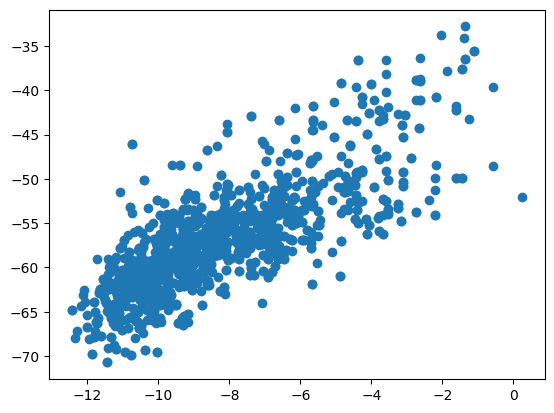

[-40.45586332   1.98171289]


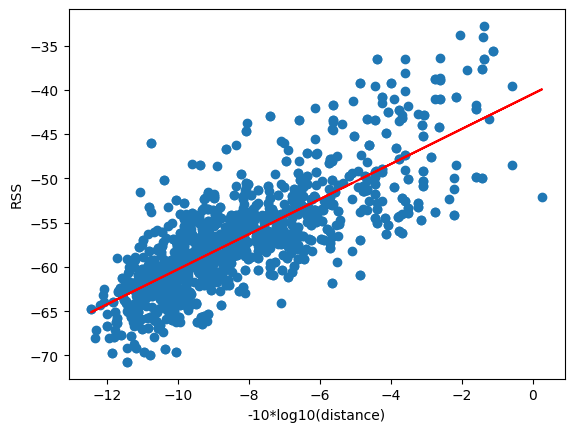

R2 score:  0.6003988641025981
-40.455863318961235 [1.98171289]
3.8460602989668127
MSE:  14.792179823288688


In [5]:
# path = "C:\\Users\\zubai\\Downloads\\dataset_for_project\\dataset_for_project"
locations_path = os.path.join("locations.txt")
rss_path = os.path.join("rss_values.txt")

# each row for one transmitter - 34 (total 43)

#read data from locations.txt
locations = []
fobj = open(locations_path, "r")
c=0
# append the data to the list
for line in fobj:
    locations.append(line.split())
    locations[c] = [float(i) for i in locations[c]]
    c+=1

fobj.close()
# print(locations)

#read data from rss.txt
rss = []
fobj = open(rss_path, "r")
c=0
for line in fobj:
    rss.append(line.split())
    c+=1
fobj.close()
# print(rss)
tx =[]
rss_no_inf = [[] for i in range(len(rss))]
for i in range(len(rss)):
    for j in range(len(rss[i])):
        if rss[i][j] == 'Inf':
            rss[i][j] = 0
            tx.append(j)
        else:
            rss[i][j] = float(rss[i][j])
            rss_no_inf[i].append(float(rss[i][j]))
            


# 44 transmitters, inf value when sensor i is the Tx
# calculate the distance between Tx and all sensors
distances=[]
for ele in tx:
    d = []
    for i in range(len(locations)):
        d.append(distance(locations[i],locations[ele]))
    distances.append(d)
print("Distance from Tx to all sensors")
print(distances)
print("Length of distances: ", len(distances), len(distances[0]))

# make an array x and y containing the distances and the rss values
x =[]
y =[]
for i in range(len(distances)):
    if len(distances[i]) != len(rss[i]):
        print("error")
    x.extend(distances[i])
    y.extend(rss[i])

# check if x has zeros and remove them
for i in range(len(x)-1, -1, -1):
    if x[i] == 0:
        # print(i)
        x.pop(i)
        y.pop(i)
# multiply each value in x by -10 log10
print(len(x), len(y))
x = np.array(x)
x = -10*np.log10(x)
x = x.reshape(-1,1)
# print(x)
plt.scatter(x,y)
plt.show()
# apply OLS

x = np.c_[np.ones((x.shape[0], 1)), x]
b = OLS(x,y)
print(b)

# plot the line
x = x[:,1]
plt.scatter(x,y)
plt.plot(x, b[0] + b[1]*x, 'r')
plt.xlabel('-10*log10(distance)')
plt.ylabel('RSS')
plt.show()

# calculate the r2 score
y_pred = b[0] + b[1]*x
r2 = r2_score(y, y_pred)
print("R2 score: ",r2)

# calculate the nsme
y = np.array(y)


# use sklearn to check the result
from sklearn.linear_model import LinearRegression
lin_reg = LinearRegression()
lin_reg.fit(x.reshape(-1,1), y)
print(lin_reg.intercept_, lin_reg.coef_)

# find the difference in actual rss and predicted rss
y_pred = b[0] + b[1]*x
diff = y - y_pred
var = np.var(diff)
X = np.sqrt(var)
print(X)


mse = mean_squared_error(y, y_pred)
print("MSE: ", mse)




Create mask images, 1 TX -> 1 image (43 RX)

(56, 52)
34


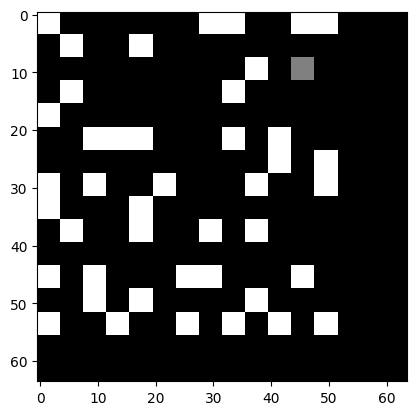

In [6]:
# generate input images for unet
images=[]
scale_factor = 4
image_width = 13*scale_factor
image_height = 14*scale_factor
image = np.zeros((image_height, image_width))
print(image.shape)
# print(image[13][3])
x_corr = []
y_corr = []

# i=0
x_min = np.min([ele[0] for ele in locations])
y_min = np.min([ele[1] for ele in locations])

# make an image where rx are denoted by 2 and tx are denoted by 1


for ele in locations:
    
    x = int(ele[0]-x_min)
    y = int(ele[1]-y_min)
    x_corr.append(x)
    y_corr.append(y)
    image[x*scale_factor][y*scale_factor] = 2
    for i in range(x*scale_factor, x*scale_factor+scale_factor):
        for j in range(y*scale_factor, y*scale_factor+scale_factor):
            image[i][j] = 2

# one rx spans 4x4 pixels
# one tx spans 4x4 pixels

image = np.array(image)
for i in range(34):
    images.append(image)
tx_images = []

# make separate images for each tx

for i in range(34):
    image_tx = images[i].copy()
    tx_i = tx[i]
    x_i = x_corr[tx_i]
    y_i = y_corr[tx_i]
    image_tx[x_i*scale_factor][y_i*scale_factor] = 1
    for i in range(x_i*scale_factor, x_i*scale_factor+scale_factor):
        for j in range(y_i*scale_factor, y_i*scale_factor+scale_factor):
            image_tx[i][j] = 1
    tx_images.append(image_tx)
    # print(tx_images[i]) 

# add 0s in the corners to make image 256x256
n_tx_images = [] 
for i in range(34):
    image = tx_images[i].copy()
    image = cv2.copyMakeBorder(image, 0, 64-image_height, 0, 64-image_width, cv2.BORDER_CONSTANT, value=0)
    # tx_images[i] = image
    n_tx_images.append(image)
    # print(tx_images[i].shape)


print(len(images))
plt.imshow(n_tx_images[0], cmap='gray')
plt.show()



In [7]:

new_rss = np.zeros((len(rss), len(rss[0])))
mins = []
maxs = []


# get min and max value of rss
min_rss = np.min(rss_no_inf)
max_rss = np.max(rss_no_inf)

for row in range(len(rss)):
    # normalize the rss values
    mins.append(min_rss)
    maxs.append(max_rss)
    
    for col in range(len(rss[row])):
        if rss[row][col] == 0:
            new_rss[row][col] = 0
        else:
            new_rss[row][col] = (rss[row][col] - min_rss)/(max_rss - min_rss)
            if new_rss[row][col] == 1:
                new_rss[row][col] = 0.999999
            if new_rss[row][col] == 0 and rss[row][col] != 0:
                new_rss[row][col] = 0.000001
                # print("error")
                # print(col)
    # print(rss[row])
    # print(new_rss[row])
        
    # print(rss[row])
images_mask=[list() for i in range(34)]

print(len(new_rss))
print(len(images))
for row in range(len(new_rss)):

    image_i = images[row].copy()
    print("new row")
    print(row)

    for col in range(len(new_rss[row])):
        s=1
        if new_rss[row][col] == 0:
            image_i[x_corr[col]*scale_factor][y_corr[col]*scale_factor] = 1
            print(row,col,"tx")
            print(x_corr[col], y_corr[col])
        else:
            image_i[x_corr[col]*scale_factor][y_corr[col]*scale_factor] = new_rss[row][col]
            s=new_rss[row][col]

        for i in range(x_corr[col]*scale_factor, x_corr[col]*scale_factor+scale_factor):
            for j in range(y_corr[col]*scale_factor, y_corr[col]*scale_factor+scale_factor):
                image_i[i][j] = s

    print(image_i.shape)
    # images_mask.append(image_i)
    images_mask[row] = image_i
    
    # give error if any value is 2
    for i in range(len(image_i)):
        for j in range(len(image_i[0])):
            if image_i[i][j] == 2:
                print("error")
    # plt.imshow(image_i, cmap='gray')
    # plt.show()
   
# print(len(images_mask))
# print("intermidiate")
# print(images_mask[0])
# plt.imshow(images_mask[22], cmap='gray')
# plt.show()

# add 0s in the corners to make image 64x64
n_images_mask=[]
for i in range(len(images_mask)):
    image = images_mask[i].copy()
    image = cv2.copyMakeBorder(image, 0, 64-image_height, 0, 64-image_width, cv2.BORDER_CONSTANT, value=0)
    n_images_mask.append(image)
    # plt.imshow(image, cmap='gray')
    # plt.show()
    # print(images_mask[i].shape)
print(images_mask[0])

34
34
new row
0
0 1 tx
2 11
(56, 52)
new row
1
1 2 tx
0 11
(56, 52)
new row
2
2 3 tx
3 8
(56, 52)
new row
3
3 5 tx
0 7
(56, 52)
new row
4
4 6 tx
0 8
(56, 52)
new row
5
5 7 tx
1 4
(56, 52)
new row
6
6 8 tx
3 1
(56, 52)
new row
7
7 10 tx
0 0
(56, 52)
new row
8
8 11 tx
4 0
(56, 52)
new row
9
9 12 tx
7 0
(56, 52)
new row
10
10 13 tx
7 2
(56, 52)
new row
11
11 15 tx
7 9
(56, 52)
new row
12
12 16 tx
7 12
(56, 52)
new row
13
13 17 tx
6 10
(56, 52)
new row
14
14 18 tx
5 10
(56, 52)
new row
15
15 20 tx
9 9
(56, 52)
new row
16
16 21 tx
5 8
(56, 52)
new row
17
17 22 tx
9 7
(56, 52)
new row
18
18 23 tx
9 4
(56, 52)
new row
19
19 25 tx
5 3
(56, 52)
new row
20
20 26 tx
5 4
(56, 52)
new row
21
21 27 tx
5 2
(56, 52)
new row
22
22 28 tx
9 1
(56, 52)
new row
23
23 30 tx
11 0
(56, 52)
new row
24
24 31 tx
13 3
(56, 52)
new row
25
25 32 tx
13 6
(56, 52)
new row
26
26 33 tx
13 8
(56, 52)
new row
27
27 35 tx
13 12
(56, 52)
new row
28
28 36 tx
11 11
(56, 52)
new row
29
29 37 tx
11 7
(56, 52)
new row
30
30 38 

Doing data augmentation. 1 Tx -> 20 images (8 random Rxs)

Format: rss values between 0 and 1 (min max scaling). 0 -> no sensor, 1 -> Tx, 2 -> sensor 

In [8]:
# scale the values between 0 and 1

new_rss = np.zeros((len(rss), len(rss[0])))
mins = []
maxs = []
min_rss = np.min(rss_no_inf)
max_rss = np.max(rss_no_inf)
for row in range(len(rss)):
    # normalize the rss values
    mins.append(min_rss)
    maxs.append(max_rss)
    
    for col in range(len(rss[row])):
        if rss[row][col] == 0:
            new_rss[row][col] = 0
        else:
            new_rss[row][col] = (rss[row][col] - min_rss)/(max_rss - min_rss)
            if new_rss[row][col] == 1:
                new_rss[row][col] = 0.999999
            if new_rss[row][col] == 0 and rss[row][col] != 0:
                new_rss[row][col] = 0.000001
                # print("error")
                # print(col)
    # print(rss[row])
    # print(new_rss[row])
        
    # print(rss[row])
images_mask=[list() for i in range(34)]

print(len(new_rss))
print(len(images))

# print(len(row_rss))




34
34


In [9]:
print(min_rss, max_rss)

-70.735108623 -32.7877407351


[array([13,  3, 34, 42, 32,  1, 11, 29]), array([13, 27, 23, 17, 29,  1, 19,  7]), array([17, 38,  2, 12,  9, 39, 26, 37]), array([12, 15, 19, 42,  4, 26, 18, 27]), array([ 3, 27, 36, 20, 35, 21,  1, 25]), array([ 8, 37, 19,  6, 16, 17, 27,  9]), array([38, 26,  4, 31,  6, 21, 42, 19]), array([24, 41, 12, 20,  8, 42, 37, 18]), array([33, 15, 37, 26,  0, 35, 34, 39]), array([ 8, 20, 25,  2, 32, 30, 21, 16]), array([32,  6, 35, 15,  4, 24, 19, 18]), array([36, 41, 30,  8, 17,  4,  7, 35]), array([10, 41, 39, 31, 21, 30,  4,  0]), array([22, 19, 20,  6, 35, 17, 29,  3]), array([37, 30,  4,  2,  7, 24, 31, 19]), array([27, 34, 15, 41, 31,  8, 21, 10]), array([31,  0, 27, 30,  9, 40, 18,  2]), array([28, 33, 30,  1, 15, 19, 18,  4]), array([34, 29,  5, 14,  7, 30, 11,  1]), array([ 0, 12,  9, 26,  2, 17,  6, 20])]
(56, 52)
680
(64, 64)


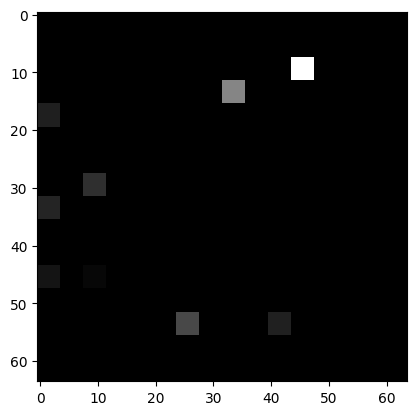

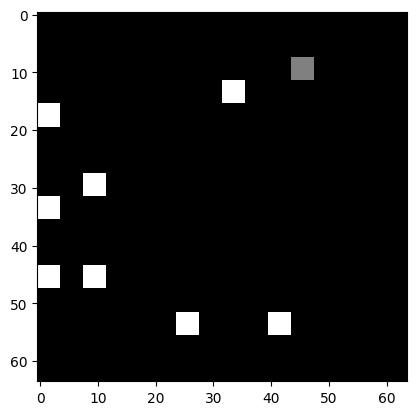

In [10]:
# data augmentation
# sample the receivers 
rx=[]
t=[]
# store 0-7 in one matrix, 7-15 and so on
for i in range(0,20):
    # get 8 random numbers between 0-44 unique
    t = np.random.choice(43, 8, replace=False)
    rx.append(t)

print(rx)


# generate input images for unet
images=[]
scale_factor = 4
image_width = 13*scale_factor
image_height = 14*scale_factor
image = np.zeros((image_height, image_width))
print(image.shape)
# print(image[13][3])
# x_corr = []
# y_corr = []
# i=0
x_min = np.min([ele[0] for ele in locations])
y_min = np.min([ele[1] for ele in locations])
k=0
txs = []
augmented_images = []
augmented_masks=[]
row_rss=[]

# creating the augmented images

for k in range(34):
    for rx_i in rx:
        tx_i = tx[k]
        row_rss.append(k)
        txs.append(tx_i)
        
        # if tx_i in rx_i then replace by a number between 0-43 not in rx_i
        image = np.zeros((image_height, image_width))
        image2 = np.zeros((image_height, image_width))
        for j in range(8):
            if tx_i == rx_i[j]:
                while True:
                    temp = np.random.randint(0, 43)
                    if temp not in rx_i:
                        break

                rx_i[j] = temp

            # print(rx_i[j])
            x = int(locations[rx_i[j]][0]-x_min)
            y = int(locations[rx_i[j]][1]-y_min)

            # x_corr.append(x)
            # y_corr.append(y)

            image[x*scale_factor][y*scale_factor] = 2
            image2[x*scale_factor][y*scale_factor] = new_rss[k][rx_i[j]]

            for i in range(x*scale_factor, x*scale_factor+scale_factor):
                for l in range(y*scale_factor, y*scale_factor+scale_factor):
                    image[i][l] = 2
                    image2[i][l] = new_rss[k][rx_i[j]]

            
        # making all the transmitter pixels 1

        # tx_i = tx[i]
        x_i = int(locations[tx_i][0]-x_min)
        y_i = int(locations[tx_i][1]-y_min)
        image[x_i*scale_factor][y_i*scale_factor] = 1
        for i in range(x_i*scale_factor, x_i*scale_factor+scale_factor):
            for j in range(y_i*scale_factor, y_i*scale_factor+scale_factor):
                image[i][j] = 1
                image2[i][j] = 1

        image = np.array(image)
        image = cv2.copyMakeBorder(image, 0, 64-image_height, 0, 64-image_width, cv2.BORDER_CONSTANT, value=0)
        image2 = cv2.copyMakeBorder(image2, 0, 64-image_height, 0, 64-image_width, cv2.BORDER_CONSTANT, value=0)

        augmented_images.append(image)
        augmented_masks.append(image2)
        # print(rx_i)
        # plt.imshow(image, cmap='gray')
        # plt.show()
        # break

print(len(augmented_images))
print(augmented_images[0].shape)
plt.imshow(augmented_masks[0], cmap='gray')
plt.show()
plt.imshow(augmented_images[0], cmap='gray')
plt.show()
            



Create unet

RadioUNet architecture 
Reference: https://github.com/RonLevie/RadioUNet/blob/master/RadioWNet_c_DPM_Thr2.ipynb

In [11]:
def convrelu(in_channels, out_channels, kernel, padding, pool):
    return nn.Sequential(
        nn.Conv2d(in_channels, out_channels, kernel, padding=padding),
        #In conv, the dimension of the output, if the input is H,W, is
        # H+2*padding-kernel +1
        nn.ReLU(inplace=True),
        nn.MaxPool2d(pool, stride=pool, padding=0, dilation=1, return_indices=False, ceil_mode=False) 
        #pooling takes Height H and width W to (H-pool)/pool+1 = H/pool, and floor. Same for W.
        #altogether, the output size is (H+2*padding-kernel +1)/pool. 
    )

def convreluT(in_channels, out_channels, kernel, padding):
    return nn.Sequential(
        nn.ConvTranspose2d(in_channels, out_channels, kernel, stride=2, padding=padding),
        nn.ReLU(inplace=True)
        #input is H X W, output is   (H-1)*2 - 2*padding + kernel
    )


    
class RadioWNet(nn.Module):

    def __init__(self,inputs=1,phase="firstU"):
        super().__init__()
        
        self.inputs=inputs
        self.phase=phase
        
        if inputs<=3:
            self.layer00 = convrelu(inputs, 6, 3, 1,1) 
            self.layer0 = convrelu(6, 40, 5, 2,2) 
        else:
            self.layer00 = convrelu(inputs, 10, 3, 1,1) 
            self.layer0 = convrelu(10, 40, 5, 2,2) 
         
        self.layer1 = convrelu(40, 50, 5, 2,2)  
        self.layer10 = convrelu(50, 60, 5, 2,1)  
        self.layer2 = convrelu(60, 100, 5, 2,2) 
        self.layer20 = convrelu(100, 100, 3, 1,1) 
        self.layer3 = convrelu(100, 150, 5, 2,2) 
        self.layer4 =convrelu(150, 300, 5, 2,2) 
        self.layer5 =convrelu(300, 500, 5, 2,2) 
        
        self.conv_up5 =convreluT(500, 300, 4, 1)  
        self.conv_up4 = convreluT(300+300, 150, 4, 1) 
        self.conv_up3 = convreluT(150 + 150, 100, 4, 1) 
        self.conv_up20 = convrelu(100 + 100, 100, 3, 1, 1) 
        self.conv_up2 = convreluT(100 + 100, 60, 6, 2) 
        self.conv_up10 = convrelu(60 + 60, 50, 5, 2, 1) 
        self.conv_up1 = convreluT(50 + 50, 40, 6, 2)
        self.conv_up0 = convreluT(40 + 40, 20, 6, 2) 
        if inputs<=3:
            self.conv_up00 = convrelu(20+6+inputs, 20, 5, 2,1)
           
        else:
            self.conv_up00 = convrelu(20+10+inputs, 20, 5, 2,1)
        
        self.conv_up000 = convrelu(20+inputs, 1, 5, 2,1)
        
        self.Wlayer00 = convrelu(inputs+1, 20, 3, 1,1) 
        self.Wlayer0 = convrelu(20, 30, 5, 2,2)  
        self.Wlayer1 = convrelu(30, 40, 5, 2,2)  
        self.Wlayer10 = convrelu(40, 50, 5, 2,1)  
        self.Wlayer2 = convrelu(50, 60, 5, 2,2) 
        self.Wlayer20 = convrelu(60, 70, 3, 1,1) 
        self.Wlayer3 = convrelu(70, 90, 5, 2,2) 
        self.Wlayer4 =convrelu(90, 110, 5, 2,2) 
        self.Wlayer5 =convrelu(110, 150, 5, 2,2) 
        
        self.Wconv_up5 =convreluT(150, 110, 4, 1)  
        self.Wconv_up4 = convreluT(110+110, 90, 4, 1) 
        self.Wconv_up3 = convreluT(90 + 90, 70, 4, 1) 
        self.Wconv_up20 = convrelu(70 + 70, 60, 3, 1, 1) 
        self.Wconv_up2 = convreluT(60 + 60, 50, 6, 2) 
        self.Wconv_up10 = convrelu(50 + 50, 40, 5, 2, 1) 
        self.Wconv_up1 = convreluT(40 + 40, 30, 6, 2)
        self.Wconv_up0 = convreluT(30 + 30, 20, 6, 2) 
        self.Wconv_up00 = convrelu(20+20+inputs+1, 20, 5, 2,1)
        self.Wconv_up000 = convrelu(20+inputs+1, 1, 5, 2,1)

    def forward(self, input):
        
        input0=input[:,0:self.inputs,:,:]
        # print(input0.shape)
        
        if self.phase=="firstU":
            layer00 = self.layer00(input0)
            # print("00",layer00.shape)
            layer0 = self.layer0(layer00)
            # print("0",layer0.shape)
            layer1 = self.layer1(layer0)
            # print("1",layer1.shape)
            layer10 = self.layer10(layer1)
            # print("10",layer10.shape)
            layer2 = self.layer2(layer10)
            layer20 = self.layer20(layer2)
            layer3 = self.layer3(layer20)
            layer4 = self.layer4(layer3)
            layer5 = self.layer5(layer4)
        
            layer4u = self.conv_up5(layer5)
            layer4u = torch.cat([layer4u, layer4], dim=1)
            layer3u = self.conv_up4(layer4u)
            layer3u = torch.cat([layer3u, layer3], dim=1)
            layer20u = self.conv_up3(layer3u)
            layer20u = torch.cat([layer20u, layer20], dim=1)
            layer2u = self.conv_up20(layer20u)
            layer2u = torch.cat([layer2u, layer2], dim=1)
            layer10u = self.conv_up2(layer2u)
            layer10u = torch.cat([layer10u, layer10], dim=1)
            layer1u = self.conv_up10(layer10u)
            layer1u = torch.cat([layer1u, layer1], dim=1)
            layer0u = self.conv_up1(layer1u)
            layer0u = torch.cat([layer0u, layer0], dim=1)
            layer00u = self.conv_up0(layer0u)
            layer00u = torch.cat([layer00u, layer00], dim=1)
            layer00u = torch.cat([layer00u,input0], dim=1)
            layer000u  = self.conv_up00(layer00u)
            layer000u = torch.cat([layer000u,input0], dim=1)
            output1  = self.conv_up000(layer000u)
        
            Winput=torch.cat([output1, input], dim=1).detach()
        
            Wlayer00 = self.Wlayer00(Winput).detach()
            Wlayer0 = self.Wlayer0(Wlayer00).detach()
            Wlayer1 = self.Wlayer1(Wlayer0).detach()
            Wlayer10 = self.Wlayer10(Wlayer1).detach()
            Wlayer2 = self.Wlayer2(Wlayer10).detach()
            Wlayer20 = self.Wlayer20(Wlayer2).detach()
            Wlayer3 = self.Wlayer3(Wlayer20).detach()
            Wlayer4 = self.Wlayer4(Wlayer3).detach()
            Wlayer5 = self.Wlayer5(Wlayer4).detach()
        
            Wlayer4u = self.Wconv_up5(Wlayer5).detach()
            Wlayer4u = torch.cat([Wlayer4u, Wlayer4], dim=1).detach()
            Wlayer3u = self.Wconv_up4(Wlayer4u).detach()
            Wlayer3u = torch.cat([Wlayer3u, Wlayer3], dim=1).detach()
            Wlayer20u = self.Wconv_up3(Wlayer3u).detach()
            Wlayer20u = torch.cat([Wlayer20u, Wlayer20], dim=1).detach()
            Wlayer2u = self.Wconv_up20(Wlayer20u).detach()
            Wlayer2u = torch.cat([Wlayer2u, Wlayer2], dim=1).detach()
            Wlayer10u = self.Wconv_up2(Wlayer2u).detach()
            Wlayer10u = torch.cat([Wlayer10u, Wlayer10], dim=1).detach()
            Wlayer1u = self.Wconv_up10(Wlayer10u).detach()
            Wlayer1u = torch.cat([Wlayer1u, Wlayer1], dim=1).detach()
            Wlayer0u = self.Wconv_up1(Wlayer1u).detach()
            Wlayer0u = torch.cat([Wlayer0u, Wlayer0], dim=1).detach()
            Wlayer00u = self.Wconv_up0(Wlayer0u).detach()
            Wlayer00u = torch.cat([Wlayer00u, Wlayer00], dim=1).detach()
            Wlayer00u = torch.cat([Wlayer00u,Winput], dim=1).detach()
            Wlayer000u  = self.Wconv_up00(Wlayer00u).detach()
            Wlayer000u = torch.cat([Wlayer000u,Winput], dim=1).detach()
            output2  = self.Wconv_up000(Wlayer000u).detach()
            
        else:
            layer00 = self.layer00(input0).detach()
            layer0 = self.layer0(layer00).detach()
            layer1 = self.layer1(layer0).detach()
            layer10 = self.layer10(layer1).detach()
            layer2 = self.layer2(layer10).detach()
            layer20 = self.layer20(layer2).detach()
            layer3 = self.layer3(layer20).detach()
            layer4 = self.layer4(layer3).detach()
            layer5 = self.layer5(layer4).detach()
        
            layer4u = self.conv_up5(layer5).detach()
            layer4u = torch.cat([layer4u, layer4], dim=1).detach()
            layer3u = self.conv_up4(layer4u).detach()
            layer3u = torch.cat([layer3u, layer3], dim=1).detach()
            layer20u = self.conv_up3(layer3u).detach()
            layer20u = torch.cat([layer20u, layer20], dim=1).detach()
            layer2u = self.conv_up20(layer20u).detach()
            layer2u = torch.cat([layer2u, layer2], dim=1).detach()
            layer10u = self.conv_up2(layer2u).detach()
            layer10u = torch.cat([layer10u, layer10], dim=1).detach()
            layer1u = self.conv_up10(layer10u).detach()
            layer1u = torch.cat([layer1u, layer1], dim=1).detach()
            layer0u = self.conv_up1(layer1u).detach()
            layer0u = torch.cat([layer0u, layer0], dim=1).detach()
            layer00u = self.conv_up0(layer0u).detach()
            layer00u = torch.cat([layer00u, layer00], dim=1).detach()
            layer00u = torch.cat([layer00u,input0], dim=1).detach()
            layer000u  = self.conv_up00(layer00u).detach()
            layer000u = torch.cat([layer000u,input0], dim=1).detach()
            output1  = self.conv_up000(layer000u).detach()
        
            Winput=torch.cat([output1, input], dim=1).detach()
        
            Wlayer00 = self.Wlayer00(Winput)
            Wlayer0 = self.Wlayer0(Wlayer00)
            Wlayer1 = self.Wlayer1(Wlayer0)
            Wlayer10 = self.Wlayer10(Wlayer1)
            Wlayer2 = self.Wlayer2(Wlayer10)
            Wlayer20 = self.Wlayer20(Wlayer2)
            Wlayer3 = self.Wlayer3(Wlayer20)
            Wlayer4 = self.Wlayer4(Wlayer3)
            Wlayer5 = self.Wlayer5(Wlayer4)
        
            Wlayer4u = self.Wconv_up5(Wlayer5)
            Wlayer4u = torch.cat([Wlayer4u, Wlayer4], dim=1)
            Wlayer3u = self.Wconv_up4(Wlayer4u)
            Wlayer3u = torch.cat([Wlayer3u, Wlayer3], dim=1)
            Wlayer20u = self.Wconv_up3(Wlayer3u)
            Wlayer20u = torch.cat([Wlayer20u, Wlayer20], dim=1)
            Wlayer2u = self.Wconv_up20(Wlayer20u)
            Wlayer2u = torch.cat([Wlayer2u, Wlayer2], dim=1)
            Wlayer10u = self.Wconv_up2(Wlayer2u)
            Wlayer10u = torch.cat([Wlayer10u, Wlayer10], dim=1)
            Wlayer1u = self.Wconv_up10(Wlayer10u)
            Wlayer1u = torch.cat([Wlayer1u, Wlayer1], dim=1)
            Wlayer0u = self.Wconv_up1(Wlayer1u)
            Wlayer0u = torch.cat([Wlayer0u, Wlayer0], dim=1)
            Wlayer00u = self.Wconv_up0(Wlayer0u)
            Wlayer00u = torch.cat([Wlayer00u, Wlayer00], dim=1)
            Wlayer00u = torch.cat([Wlayer00u,Winput], dim=1)
            Wlayer000u  = self.Wconv_up00(Wlayer00u)
            Wlayer000u = torch.cat([Wlayer000u,Winput], dim=1)
            output2  = self.Wconv_up000(Wlayer000u)
        
        # return [output1,output2]
        return output2
    

Model summary

In [12]:
%pip install torchsummary
# model summary
from torchsummary import summary
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
torch.set_default_dtype(torch.float32)
torch.set_default_tensor_type(torch.FloatTensor)
model = RadioWNet(phase="secondU").to(device)
model.to(device)
summary(model, input_size=(1, 64, 64))


[notice] A new release of pip is available: 23.3.1 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip
c:\Users\yusuf\AppData\Local\Programs\Python\Python310\lib\site-packages\torch\__init__.py:696: UserWarning: torch.set_default_tensor_type() is deprecated as of PyTorch 2.1, please use torch.set_default_dtype() and torch.set_default_device() as alternatives. (Triggered internally at ..\torch\csrc\tensor\python_tensor.cpp:453.)
  _C._set_default_tensor_type(t)


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 6, 64, 64]              60
              ReLU-2            [-1, 6, 64, 64]               0
         MaxPool2d-3            [-1, 6, 64, 64]               0
            Conv2d-4           [-1, 40, 64, 64]           6,040
              ReLU-5           [-1, 40, 64, 64]               0
         MaxPool2d-6           [-1, 40, 32, 32]               0
            Conv2d-7           [-1, 50, 32, 32]          50,050
              ReLU-8           [-1, 50, 32, 32]               0
         MaxPool2d-9           [-1, 50, 16, 16]               0
           Conv2d-10           [-1, 60, 16, 16]          75,060
             ReLU-11           [-1, 60, 16, 16]               0
        MaxPool2d-12           [-1, 60, 16, 16]               0
           Conv2d-13          [-1, 100, 16, 16]         150,100
             ReLU-14          [-1, 100,

Make data loaders, 95% training set and 5% validation set


646 34
torch.Size([1, 1, 64, 64]) torch.Size([1, 1, 64, 64])


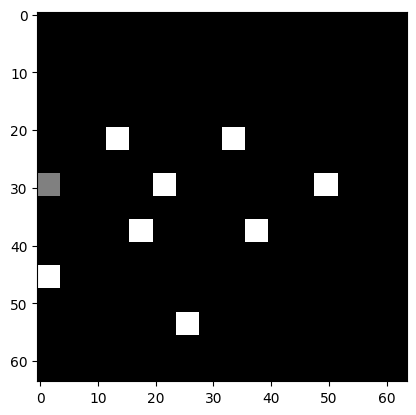

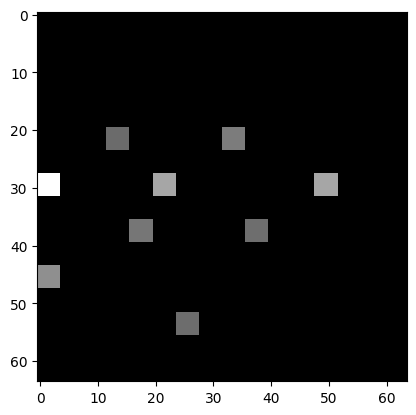

tensor([[[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]]], dtype=torch.float64)


In [13]:
# create dataloaders
class Dataset(Dataset):
    def __init__(self, images, masks, transform=None):
        self.images = images
        self.masks = masks
        self.transform = None

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        mask = self.masks[idx]

        if self.transform == None:

            transform1 = transforms.Compose([
                    transforms.ToTensor(),
                    ])
            # resize_transform = transforms.Resize((100, 100))
            image = transform1(image)
            mask = transform1(mask)

        else:
            image = self.transform(image)
            mask = self.transform(mask)

        return image, mask

# split the data into training and validation sets

tx_images = np.array(augmented_images)
images_mask = np.array(augmented_masks)
print()
train_images, val_images, train_masks, val_masks = train_test_split(tx_images, images_mask, test_size=0.05)
train_dataset = Dataset(train_images, train_masks)
val_dataset = Dataset(val_images, val_masks)
# print(len(train_dataset), len(val_dataset))
train_dataloader = DataLoader(train_dataset, batch_size=1, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=1, shuffle=False)
print(len(train_dataset), len(val_dataset))
for i, (image, mask) in enumerate(train_dataloader):
    print(image.shape, mask.shape)
    plt.imshow(image[0][0], cmap='gray')
    plt.show()
    plt.imshow(mask[0][0], cmap='gray')
    plt.show()
    print(image)
    
    break

In [14]:
n_class = 44
n_channels=1
# device = 'cpu'
op=[]
m=[]
val = []
val_m = []
# initialize the model
model2 = RadioWNet(phase="secondU").to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model2.parameters(), lr=0.001)
num_epochs = 10

for e in range(num_epochs):
    running_loss = 0
    s=0
    avgLoss = 0
    runs=0
    running_loss_v = 0
    s_v=0
    avgLoss_v = 0
    runs_v=0
    model2.train()
    for i, (image, mask) in enumerate(train_dataloader):
        image = image.to(device, dtype=torch.float32)
        mask = mask.to(device, dtype=torch.float32)
        optimizer.zero_grad()
        output = model2(image)
        
        o1 = output
        
        print(o1.shape, mask.shape)
        if e == num_epochs-1:
            op.append(o1)
            m.append(mask)

        loss = criterion(o1.float(), mask.float())

        loss.backward()
        optimizer.step()
        
        print(f'Epoch {e}, Loss: {loss.item()}')
        running_loss+=loss.item()
        s+=running_loss
        running_loss = 0.0
        runs+=1
    avgLoss = s/runs
    run.log({'Training Loss': avgLoss})
    model2.eval()
    with torch.no_grad():
        for i, (image, mask) in enumerate(val_dataloader):
            image = image.to(device, dtype=torch.float32)
            mask = mask.to(device, dtype=torch.float32)
            output = model2(image)
            if e == num_epochs-1:
                val.append(output)
                val_m.append(mask)

            loss = criterion(output, mask)
            # if i % 10 == 0:
            print(f'Epoch {e}, Validation Loss: {loss.item()}')
            running_loss_v+=loss.item()
            s_v+=running_loss_v
            running_loss_v = 0.0
            runs_v+=1
    avgLoss_v = s_v/runs_v
    run.log({'Validation Loss':avgLoss_v})

torch.Size([1, 1, 64, 64]) torch.Size([1, 1, 64, 64])
Epoch 0, Loss: 0.007660703267902136
torch.Size([1, 1, 64, 64]) torch.Size([1, 1, 64, 64])
Epoch 0, Loss: 0.008181515149772167
torch.Size([1, 1, 64, 64]) torch.Size([1, 1, 64, 64])
Epoch 0, Loss: 0.0054877083748579025
torch.Size([1, 1, 64, 64]) torch.Size([1, 1, 64, 64])
Epoch 0, Loss: 0.007656904868781567
torch.Size([1, 1, 64, 64]) torch.Size([1, 1, 64, 64])
Epoch 0, Loss: 0.004386037588119507
torch.Size([1, 1, 64, 64]) torch.Size([1, 1, 64, 64])
Epoch 0, Loss: 0.0053227972239255905
torch.Size([1, 1, 64, 64]) torch.Size([1, 1, 64, 64])
Epoch 0, Loss: 0.004967132117599249
torch.Size([1, 1, 64, 64]) torch.Size([1, 1, 64, 64])
Epoch 0, Loss: 0.003853448433801532
torch.Size([1, 1, 64, 64]) torch.Size([1, 1, 64, 64])
Epoch 0, Loss: 0.004619370214641094
torch.Size([1, 1, 64, 64]) torch.Size([1, 1, 64, 64])
Epoch 0, Loss: 0.003811553120613098
torch.Size([1, 1, 64, 64]) torch.Size([1, 1, 64, 64])
Epoch 0, Loss: 0.004479669965803623
torch.Si

Save the model

In [21]:
torch.save(model2.state_dict(), 'model_secondU_normalization_b16_e10.pth')

Visualize the images

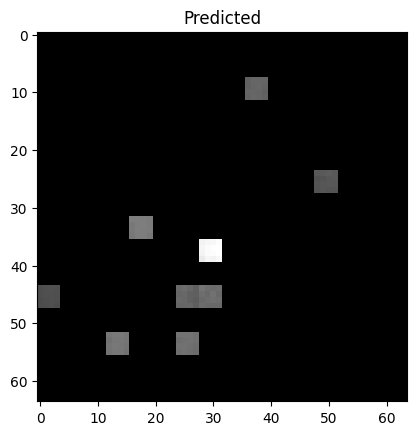

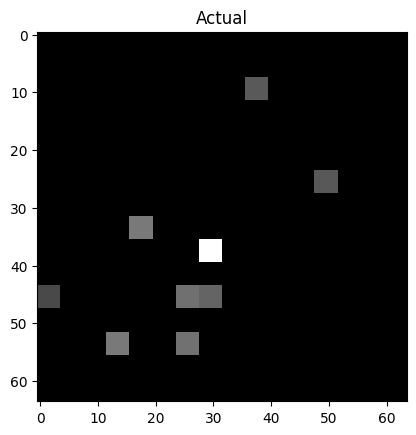

torch.Size([1, 1, 64, 64]) torch.Size([1, 1, 64, 64])
tensor(0.9321, grad_fn=<SelectBackward0>)
tensor([[[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]]])
34


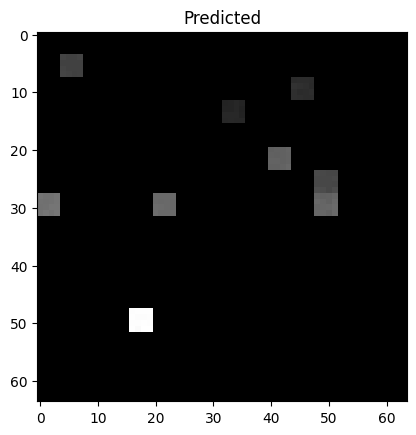

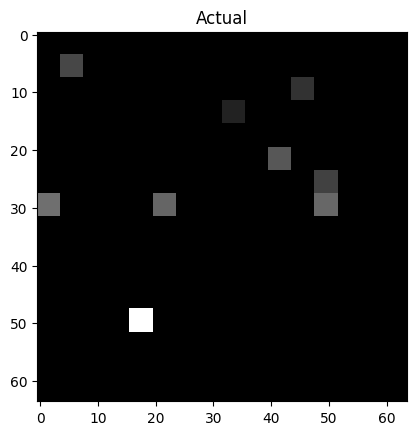

torch.Size([1, 1, 64, 64]) torch.Size([1, 1, 64, 64])
tensor([[[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]]])
tensor([[[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]]])


In [15]:
for i in range(len(op)):
    # pred = F.one_hot(op[i].argmax(dim=1), model.n_classes).permute(0, 3, 1, 2).float()
    plt.imshow(op[i][0][0].cpu().detach().numpy(), cmap='gray')
    plt.title('Predicted')
    plt.show()
    plt.imshow(m[i][0][0].cpu().detach().numpy(), cmap='gray')
    plt.title('Actual')
    plt.show()
    print(op[i].shape, m[i].shape)
    print(op[i][0][0][37][30])
    # for row in op[i][0][0]:
    #     print(row)
    print(m[i][0])
    break

print(len(val))

for i in range(len(val)):
    # pred = F.one_hot(op[i].argmax(dim=1), model.n_classes).permute(0, 3, 1, 2).float()
    plt.imshow(val[i][0][0].cpu().detach().numpy(), cmap='gray')
    plt.title('Predicted')
    plt.show()
    plt.imshow(val_m[i][0][0].cpu().detach().numpy(), cmap='gray')
    plt.title('Actual')
    plt.show()
    print(val[i].shape, val_m[i].shape)
    print(val[i])
    print(val_m[i])
    break

# for i, (image, mask) in enumerate(train_dataloader):
#     print(image.shape, mask.shape)
#     plt.imshow(mask[0][0], cmap='gray')
#     plt.show()
    

Convert image to matrix

In [16]:

def average_pooling(val):
    temp=val[0].cpu().detach().numpy()
    for i in range(0,image_height,scale_factor):
        for j in range(0,image_width,scale_factor):
            sum=0
            for i_s in range(i,i+scale_factor,1):
                for j_s in range(j,j+scale_factor,1):
                    sum+=temp[i_s][j_s]
            avg=sum/16
            for i_s in range(i,i+scale_factor,1):
                for j_s in range(j,j+scale_factor,1):
                    temp[i_s][j_s]=avg
    return temp

print(val[0][0])


tensor([[[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]]])


In [17]:
# averaging the pixels in the image to have one value for each 4x4 block
new_val_images = []
for val_im in val:
    print(val_im.shape)
    for i in range(val_im.shape[0]):
        im = average_pooling(val_im[i])
        new_val_images.append(im)
    # plt.imshow(im, cmap='gray')
    # plt.show()
    
    # break
print(len(new_val_images))
print(new_val_images[0].shape)

torch.Size([1, 1, 64, 64])
torch.Size([1, 1, 64, 64])
torch.Size([1, 1, 64, 64])
torch.Size([1, 1, 64, 64])
torch.Size([1, 1, 64, 64])
torch.Size([1, 1, 64, 64])
torch.Size([1, 1, 64, 64])
torch.Size([1, 1, 64, 64])
torch.Size([1, 1, 64, 64])
torch.Size([1, 1, 64, 64])
torch.Size([1, 1, 64, 64])
torch.Size([1, 1, 64, 64])
torch.Size([1, 1, 64, 64])
torch.Size([1, 1, 64, 64])
torch.Size([1, 1, 64, 64])
torch.Size([1, 1, 64, 64])
torch.Size([1, 1, 64, 64])
torch.Size([1, 1, 64, 64])
torch.Size([1, 1, 64, 64])
torch.Size([1, 1, 64, 64])
torch.Size([1, 1, 64, 64])
torch.Size([1, 1, 64, 64])
torch.Size([1, 1, 64, 64])
torch.Size([1, 1, 64, 64])
torch.Size([1, 1, 64, 64])
torch.Size([1, 1, 64, 64])
torch.Size([1, 1, 64, 64])
torch.Size([1, 1, 64, 64])
torch.Size([1, 1, 64, 64])
torch.Size([1, 1, 64, 64])
torch.Size([1, 1, 64, 64])
torch.Size([1, 1, 64, 64])
torch.Size([1, 1, 64, 64])
torch.Size([1, 1, 64, 64])
34
(64, 64)


Calculate metrics for DL

In [18]:
print(tx)
print(rx)
print(len(x_corr),x_corr)
print(len(y_corr),y_corr)

# tx -> index of the transmitter
# rx -> index of the receivers
# x_corr -> x coordinate of the receivers at index i
# y_corr -> y coordinate of the receivers at index i
scaled_x_corr = [i*scale_factor for i in x_corr]
scaled_y_corr = [i*scale_factor for i in y_corr]
print(new_val_images[0].tolist())
print(len(new_val_images))
print(len(val_m))

flatten_pred=[]
flatten_actual=[]
sum_r2=0

for i in range(len(new_val_images)):
    val_im = new_val_images[i].copy()
    # flatten to a 1d array
    val_im = val_im.flatten()
    flatten_pred.extend(val_im)

for i in range(len(val_m)):
    val_im = val_m[i].cpu().detach().numpy().copy()
    val_im = val_im.flatten()
    flatten_actual.extend(val_im)


new_flatten_pred=[]
new_flatten_pred = [flatten_pred[i] for i in range(len(flatten_actual)) if flatten_actual[i] != 0]
flatten_actual = [i for i in flatten_actual if i != 0]
r2 = r2_score(flatten_actual, new_flatten_pred)
print("R2 score for validation: ",r2)



    

[1, 2, 3, 5, 6, 7, 8, 10, 11, 12, 13, 15, 16, 17, 18, 20, 21, 22, 23, 25, 26, 27, 28, 30, 31, 32, 33, 35, 36, 37, 38, 40, 41, 42]
[array([ 2, 19, 34, 36,  7, 22, 24, 29]), array([16,  4,  1, 36, 29,  0, 19,  5]), array([13, 12, 37, 10,  9, 39, 22, 16]), array([ 3, 10, 19, 23,  4, 22,  9,  5]), array([22,  9, 18,  2,  6, 28,  4, 20]), array([ 1, 16, 19,  3, 14, 12, 18,  9]), array([ 0, 25,  4, 16,  5, 24, 41, 19]), array([24,  3,  8, 18, 14, 32, 27,  0]), array([ 4, 24, 25, 23,  0, 30, 34, 39]), array([14, 29, 17, 28,  7, 21, 31, 15]), array([20,  8, 22, 18,  4, 24, 19, 15]), array([34,  7, 27, 29, 10,  4, 39, 30]), array([ 7, 11, 39, 20,  2, 34,  4,  0]), array([34, 19, 13, 24, 14,  2, 29,  1]), array([ 0,  6,  4, 27, 39, 24, 10, 19]), array([29, 34, 12, 20, 28,  9, 19,  2]), array([ 8,  0, 30, 15,  9, 31, 10,  4]), array([20, 31,  8, 15,  2, 19, 14,  4]), array([34, 29,  3, 14,  2, 23,  5, 39]), array([ 0, 28,  9,  4, 34,  2, 35, 17])]
44 [0, 2, 0, 3, 2, 0, 0, 1, 3, 1, 0, 4, 7, 7, 7, 

In [19]:
# calculate the r2 score for training data
flatten_pred=[]
flatten_actual=[]
sum_r2=0
for i in range(len(op)):
    val_im = op[i].cpu().detach().numpy().copy()
    val_im = val_im.flatten()
    flatten_pred.extend(val_im)

# remove the 0s from the arrays
for i in range(len(m)):
    val_im = m[i].cpu().detach().numpy().copy()
    val_im = val_im.flatten()
    flatten_actual.extend(val_im)

new_flatten_pred=[]

new_flatten_pred = [flatten_pred[i] for i in range(len(flatten_actual)) if flatten_actual[i] != 0]
flatten_actual = [i for i in flatten_actual if i != 0]
r2 = r2_score(flatten_actual, new_flatten_pred)
print("R2 score for training: ",r2)


R2 score for training:  0.9804248326017896


In [20]:
# calcualte mse 
mse = mean_squared_error(flatten_actual, new_flatten_pred)
print("MSE for validation data: ",mse)


MSE for validation data:  0.0012520124
